# Diplomatura en ciencia de datos, aprendizaje automático y sus aplicaciones - Edición 2023 - FAMAF (UNC)

## Introducción al aprendizaje profundo

### Trabajo práctico entregable 2/2

- **Estudiantes:**
    - [Chevallier-Boutell, Ignacio José](https://www.linkedin.com/in/nachocheva/) (materia completa).
    - Gastelu, Gabriela (materia completa).
    - Spano, Marcelo (materia completa).

- **Docentes:**
    - Johanna Analiz Frau (Mercado Libre).
    - Nindiría Armenta Guerrero (fyo).

---

## Librerías

In [3]:
# Importando líbrerias
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import torch
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, transforms
from torchvision.utils import make_grid

from tqdm.notebook import tqdm

# Para que todo sea reproducible
torch.manual_seed(1994)

import time

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Funciones útiles

### Preparación

In [5]:
def data_preparation(BATCH_SIZE, transform):

    # Download and load the training data
    trainval_set = datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)

    # 40000 para entrenamiento y 10000 para validación
    train_split = 40000
    validate_split = 10000

    train_set, val_set = random_split(trainval_set, [train_split, validate_split])

    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=2)

    val_loader = DataLoader(val_set, batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=2)

    # Download and load the test data
    test_set = datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE,
                                            shuffle=False, num_workers=2)

    return train_set, train_loader, val_set, val_loader, test_set, test_loader

### Entrenamiento y validación

In [6]:
def train_val(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    print('>>> Running...')
    # Ciclo for para el número de épocas
    train_loss_history, train_acc_history, val_loss_history, val_acc_history = [], [], [], []
    all_labels, all_preds = [], []
    model = model.to(device=device)
    start = time.time()
    for epoch in range(1, num_epochs + 1):
        train_loss = 0.0
        train_acc = 0.0
        val_loss = 0.0
        val_acc = 0.0

        # Establecer el modelo en modo de entrenamiento
        model.train()
        y_true = []
        y_pred = []
        # Iterar sobre los datos de entrenamiento
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.long)
            optimizer.zero_grad()
            predicted_outputs = model(inputs)
            # Calcular la pérdida
            loss = criterion(predicted_outputs, labels)
            loss.backward()
            optimizer.step()
            # Acumular la pérdida y la precisión
            train_loss += loss.item()
            # La etiqueta con mayor valor será nuestra predicción
            _, predicted = torch.max(predicted_outputs , 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

        # Calcular la pérdida y precisión promedio del entrenamiento
        train_loss /= len(train_loader)
        train_loss_history.append(train_loss)
        train_acc = accuracy_score(y_true, y_pred)
        train_acc_history.append(train_acc)

        # set the model to evaluation mode
        model.eval()
        y_true = []
        y_pred = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.long)
                # Run the forward pass
                predicted_outputs = model(inputs)
                # Compute loss
                loss = criterion(predicted_outputs, labels)
                # Accumulate the average loss of the mini-batch
                val_loss += loss.item()
                # The label with the highest value will be our prediction
                _, predicted = torch.max(predicted_outputs , 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        # calculate the average validation loss and accuracy
        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)
        val_acc = accuracy_score(y_true, y_pred)
        val_acc_history.append(val_acc)
        all_labels.extend(y_true)
        all_preds.extend(y_pred)

        if (epoch % 10 == 0) and (epoch != num_epochs):
            print(f'Voy por la época {epoch}! :)')
            print(f'\t Train >> Loss: {train_loss:.4f} - Acc: {train_acc:.4f}')
            print(f'\t   Val >> Loss: {val_loss:.4f} - Acc: {val_acc:.4f}')
        elif epoch == num_epochs:
            WallTime = time.time() - start
            print(f'\tTerminé! :D')
            print(f'\t Train >> Loss: {train_loss:.4f} - Acc: {train_acc:.4f}')
            print(f'\t   Val >> Loss: {val_loss:.4f} - Acc: {val_acc:.4f}')
            print(f'<<< WallTime = {WallTime/60:.2f} min')

    modelo = model.__class__.__name__
    activacion = model.actfunc
    GD = optimizer.__class__.__name__
    LR = optimizer.param_groups[0]['lr']
    Walltime = f'{WallTime/60:.2f}'
    titulo = f'{modelo}_{activacion}_{GD}_LR-{LR}_Walltime-{Walltime}min'

    # Guardamos métricas
    Arr = np.array([train_loss_history, train_acc_history, val_loss_history, val_acc_history]).T
    df = pd.DataFrame(Arr, columns=['train_loss_history', 'train_acc_history', 'val_loss_history', 'val_acc_history'])
    df.to_csv(titulo+'_Metricas.csv', index=False)

    # Guardamos etiquetas
    Arr = np.array([all_labels, all_preds]).T
    df = pd.DataFrame(Arr, columns=['all_labels', 'all_preds'])
    df.to_csv(titulo+'_Etiquetas.csv', index=False)

    print(titulo)
    print()

### Gráficas

In [7]:
def plotting_confusion_matrix(path, CIFAR_CLASSES):
    Arr = pd.read_csv(path).to_numpy()

    # Plotting Confusion Matrix
    fig, axs = plt.subplots(figsize = (7, 6))

    # Implementing visualization of Confusion Matrix
    c_m_normalized = confusion_matrix(Arr[:,0], Arr[:,1], normalize='true').round(3)
    ConfusionMatrixDisplay(c_m_normalized*100, display_labels=CIFAR_CLASSES).plot(cmap='Greys', xticks_rotation=25, ax=axs)

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    axs.set_title('Valores porcentuales', fontsize=14)

    titulo = path.split('_Etiquetas')[0]
    if len(titulo.split('Outputs/')) == 2:
        titulo = titulo.split('Outputs/')[1]
    plt.suptitle(titulo, fontsize=16)
    plt.show()

def plot_loss_and_accuracy(path):
    Arr = pd.read_csv(path).to_numpy()

    xAxis = [x+1 for x in range(Arr.shape[0])]
    xTicks = [(k+1)*10 for k in range(int(100/10))]

    fig, axs = plt.subplots(1, 2, figsize = (10, 4))

    # Plot the training and validation loss
    axs[0].plot(xAxis, Arr[:, 0], label='train loss')
    axs[0].plot(xAxis, Arr[:, 2], label='val loss')
    axs[0].grid()
    axs[0].set_xlabel('Épocas')
    axs[0].set_xticks(xTicks)
    axs[0].set_ylabel('Loss')
    axs[0].legend(loc='upper right')


    # Plot the training and validation accuracy
    axs[1].plot(xAxis, Arr[:, 1], label='train acc')
    axs[1].plot(xAxis, Arr[:, 3], label='val acc')
    axs[1].grid()
    axs[1].set_xlabel('Épocas')
    axs[1].set_xticks(xTicks)
    axs[1].set_ylabel('Acc')
    axs[1].legend(loc='lower right')

    titulo = path.split('_Metricas')[0]
    if len(titulo.split('Outputs/')) == 2:
        titulo = titulo.split('Outputs/')[1]

    plt.suptitle(titulo, fontsize=16)
    plt.show()

---
# Descripción, carga y preprocesamiento del dataset

El dataset a utilizar es el **[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)**, el cual es un conjunto estándar para hacer reconocimiento de imágenes. Consta de 60000 imágenes RGB de 32x32 divididas en 10 clases mutuamente excluyentes (avión, auto, pájaro, gato, ciervo, perro, rana, caballo, barco y camión), con 6000 imágenes por clase. De estas 60000 hay 50000 imágenes de entrenamiento y las otras 10000 son de evaluación.

Nuestro objetivo es entrenar una CNN que clasifique los objetos de las imágenes dentro de alguna de las 10 categorías dadas.

***Observación:*** este dataset ya está incoporado dentro de las librerías de pytorch.

In [8]:
# Tamaño de lote (default)
BATCH_SIZE = 64

# Número de épocas (default)
EPOCHS = 100

# Función de pérdida
criterion = nn.CrossEntropyLoss()

# Convertimos en tensor y normalizamos, tomando el valor medio del rango
# posible, i.e. [0; 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Obtenemos el conjunto de entrenamiento y de evaluación, junto a sus loaders
train_set, train_loader, val_set, val_loader, test_set, test_loader = data_preparation(BATCH_SIZE, transform)

# Clases disponibles
CIFAR_CLASSES = test_set.classes

100%|██████████| 170498071/170498071 [00:12<00:00, 13277030.30it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


---
# Experimento 1 - Modelo de partida: Red convolucional sin padding

## Definición del modelo

La red base que usamos consta de 2 capas convolucionales:
- La primera con 3 canales de entrada (RGB de las imágenes) y 10 canales de salida.
- La segunda toma estos 10 canales de salida como canales de entrada y devuelve 20 canales de saldia.

En ambos casos los filtros son 5x5, el paso es de 1 y el relleno es nulo. Esto hace que la primera capa convolucional tome las imágenes 32x32x3 y devuelva un mapa de características de 28x28x10. Luego, el max pooling nos deja un mapa de características de 14x14x10. La segunda capa convolucional toma este mapa de 14x14x10, y devuelve otro mapa de 10x10x20, quedando en 5x5x20 luego del max pooling.

Al aplanar esta salida, la flatten layer es un vector de 500 (=5x5x20) entradas. La capa fully-connected toma estos 500 valores y devuelve 10, uno por cada clase posible.

La función de activación por defecto de esta red es la sigmoide.

In [ ]:
class NetwithoutPadding(nn.Module):
    def __init__(self):
        super(NetwithoutPadding, self).__init__()
        # Inicializar 2 capas convolucionales
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5, padding=0)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, padding=0)

        # Inicializar función de activación. Default: Sigmoide
        self.actfunc = nn.Sigmoid()

        # Inicializar una capa de agrupamiento por máximo
        self.pool = nn.MaxPool2d(2, 2)

        # Inicializar la capa totalmente conectada
        self.fc = nn.Linear(5 * 5 * 20, 10)

    def forward(self, x):
        # Convolución + Activación + Agrupamiento sobre capa 1
        x = self.actfunc(self.conv1(x))
        x = self.pool(x)

        # # Convolución + Activación + Agrupamiento sobre capa 2
        x = self.actfunc(self.conv2(x))
        x = self.pool(x)

        # Preparar la imagen para la capa totalmente conectada (flatten layer)
        x = x.view(-1, self.fc.in_features)

        # Aplicar la capa totalmente conectada y obtener resultado
        return self.fc(x)

## Corrida default: baseline.

In [ ]:
# # Instanciamos el modelo
# model = NetwithoutPadding()
# # Definimos el optimizador
# optimizer = optim.SGD(model.parameters(), lr=1e-1, momentum=0.9)
# # Corremos el experimento
# train_val(model, criterion, optimizer, train_loader, val_loader, EPOCHS)

## Estudio de la función de activación

In [ ]:
# # La sigmoide es el default
# activation_functions = [nn.Tanh(), nn.ReLU(), nn.LeakyReLU()]

# for af in activation_functions:
#     model = NetwithoutPadding()
#     model.actfunc = af
#     print(model.actfunc)
#     optimizer = optim.SGD(model.parameters(), lr=1e-1, momentum=0.9)
#     train_val(model, criterion, optimizer, train_loader, val_loader, EPOCHS)

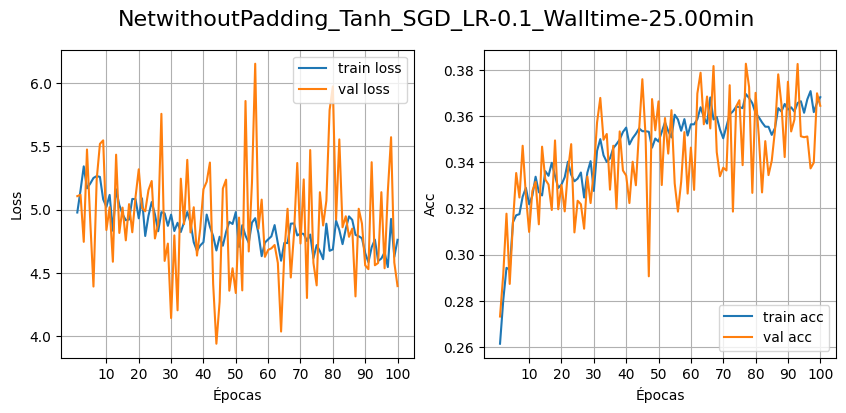

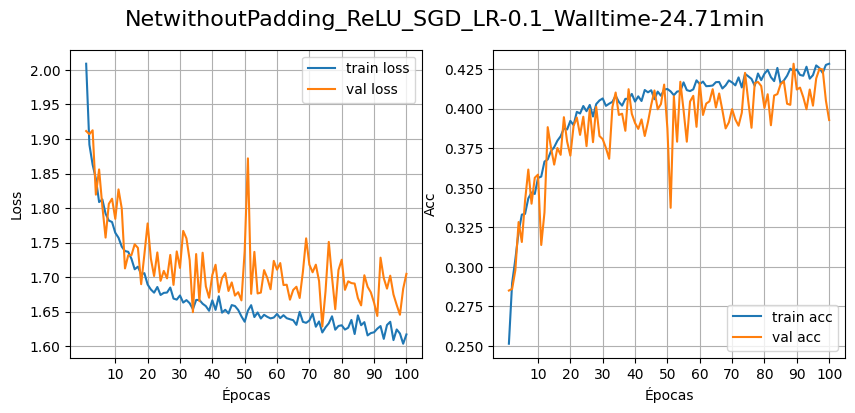

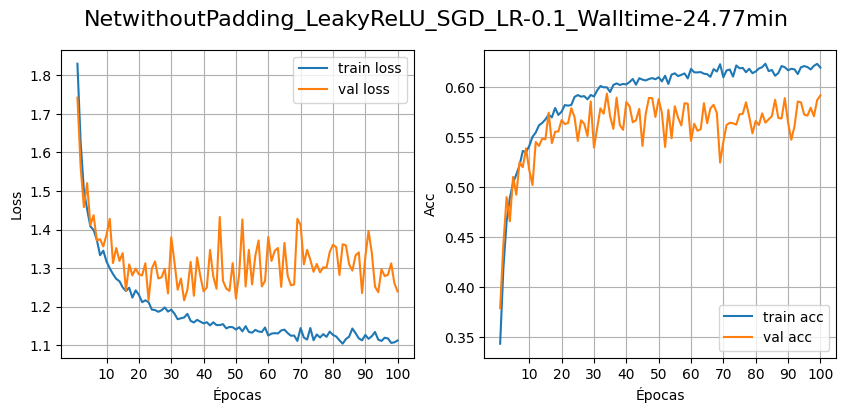

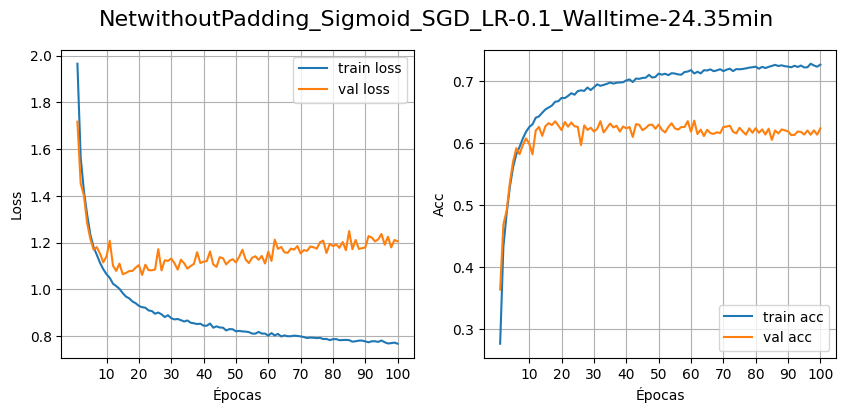

In [ ]:
prefix = 'https://raw.githubusercontent.com/Cheva94/Diplo_Opt/cheva_dl_lab2/3_DL/Lab2/Outputs/NetwithoutPadding_'
for path in ['Tanh_SGD_LR-0.1_Walltime-25.00min_Metricas.csv',
            'ReLU_SGD_LR-0.1_Walltime-24.71min_Metricas.csv',
            'LeakyReLU_SGD_LR-0.1_Walltime-24.77min_Metricas.csv',
            'Sigmoid_SGD_LR-0.1_Walltime-24.35min_Metricas.csv']:
    plot_loss_and_accuracy(prefix+path)

La Tanh se descarta porque es extremadamente ruidosa. La sigmoide (default) no es tan ruidosa, pero presenta demasiado sobreajuste. Entre las dos restantes, elegimos ReLU ya que ambas curvas se acompañan mejor que con LeakyReLU, la cual presenta un pequeño sobreajuste. Creemos que el ruido de la ReLU mejorará al variar otros hiperparámetros.

## Estudio del optimizador

In [ ]:
# # SGD es el default
# optimizadores = [optim.Adam, optim.Adagrad, optim.RMSprop, optim.Adam]

# for gd in optimizadores:
#     print(gd)
#     model = NetwithoutPadding()
#     # Adagrad no funciona sin esta línea (es un issue ya reportado)
#     model = model.to(device=device)
#     # Usamos la función de activación elegida
#     model.actfunc = nn.ReLU()
#     optimizer = gd(model.parameters(), lr=1e-1)
#     train_val(model, criterion, optimizer, train_loader, val_loader, EPOCHS)

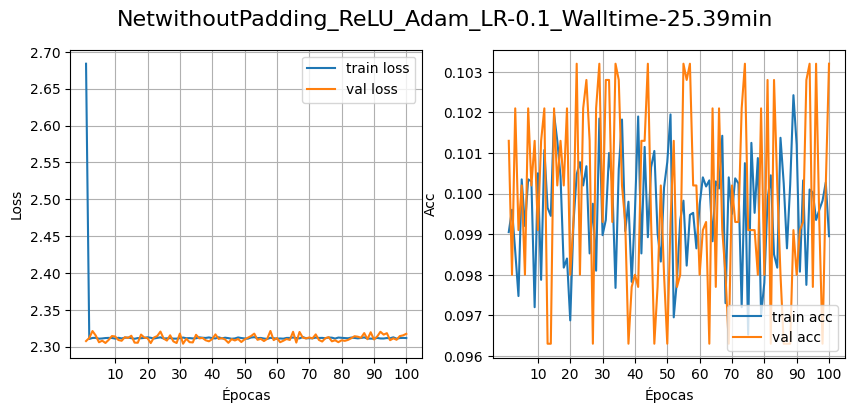

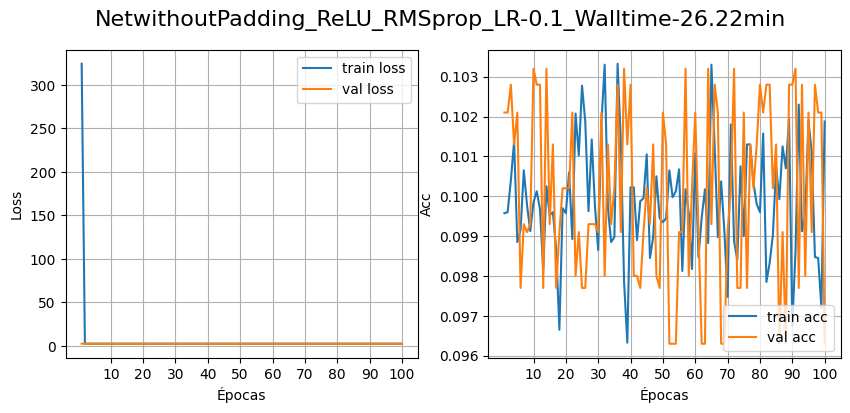

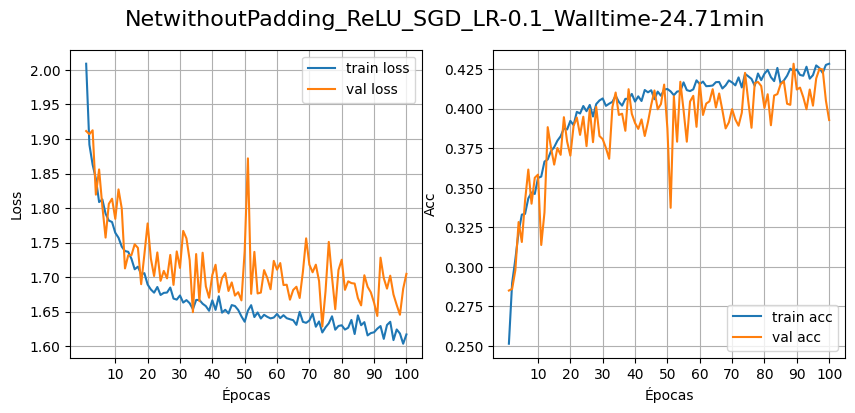

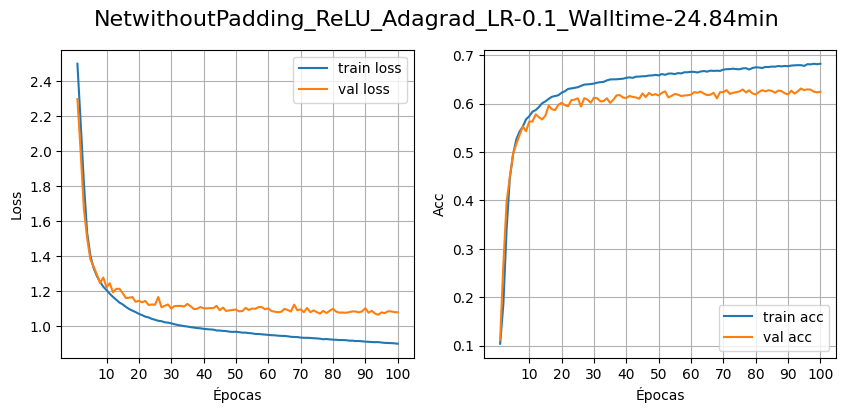

In [ ]:
prefix = 'https://raw.githubusercontent.com/Cheva94/Diplo_Opt/cheva_dl_lab2/3_DL/Lab2/Outputs/NetwithoutPadding_'
for path in ['ReLU_Adam_LR-0.1_Walltime-25.39min_Metricas.csv',
             'ReLU_RMSprop_LR-0.1_Walltime-26.22min_Metricas.csv',
             'ReLU_SGD_LR-0.1_Walltime-24.71min_Metricas.csv',
             'ReLU_Adagrad_LR-0.1_Walltime-24.84min_Metricas.csv']:
    plot_loss_and_accuracy(prefix+path)

Tanto RMSprop como Adam presentan evoluciones ruidosas. Entre SGD (default) y Adagrad, elegimos la segunda ya que ayuda a disminuir el ruido, a pesar de que se genera una brecha de sobreajuste.

## Estudio de la tasa de aprendizaje

In [ ]:
# # 0.1 es el default
# alphas = [1e-4] # [1e-2, 1e-3, 1e-4]

# for lr in alphas:
#     print(lr)
#     model = NetwithoutPadding()
#     # Adagrad no funciona sin esta línea (es un issue ya reportado)
#     model = model.to(device=device)
#     # Usamos la función de activación elegida
#     model.actfunc = nn.ReLU()
#     # Usamos el optimizador elegido
#     optimizer = optim.Adagrad(model.parameters(), lr=lr)
#     train_val(model, criterion, optimizer, train_loader, val_loader, EPOCHS)

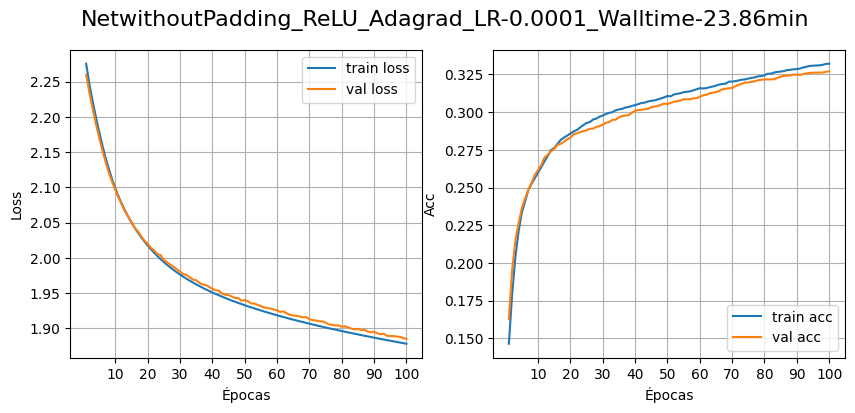

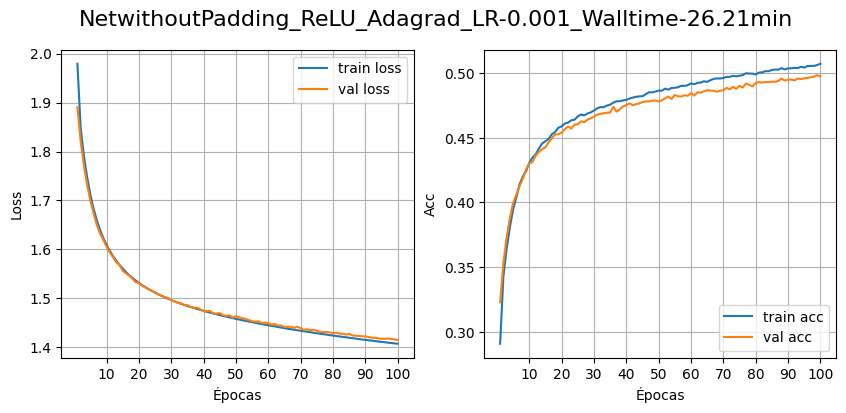

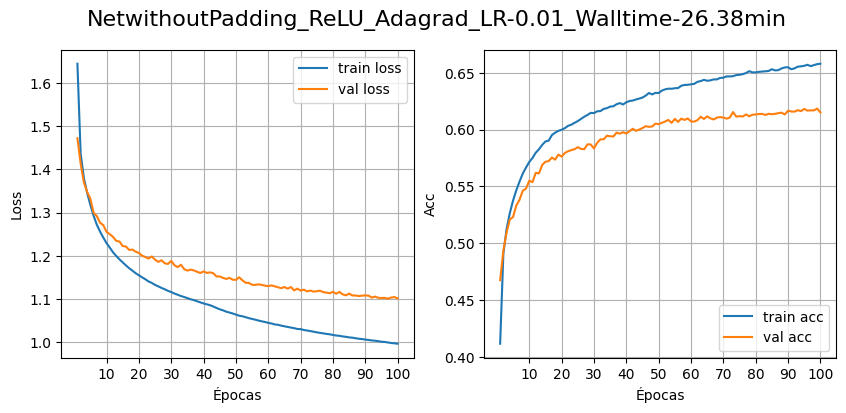

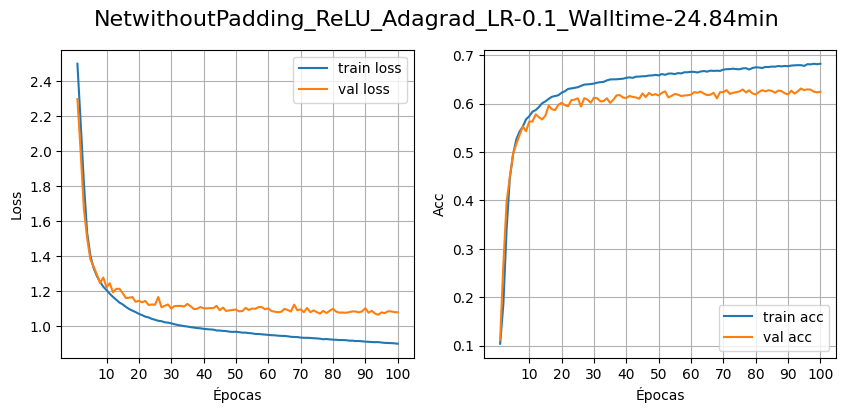

In [ ]:
prefix = 'https://raw.githubusercontent.com/Cheva94/Diplo_Opt/cheva_dl_lab2/3_DL/Lab2/Outputs/NetwithoutPadding_'
for path in ['ReLU_Adagrad_LR-0.0001_Walltime-23.86min_Metricas.csv',
             'ReLU_Adagrad_LR-0.001_Walltime-26.21min_Metricas.csv',
             'ReLU_Adagrad_LR-0.01_Walltime-26.38min_Metricas.csv',
             'ReLU_Adagrad_LR-0.1_Walltime-24.84min_Metricas.csv']:
    plot_loss_and_accuracy(prefix+path)

Si bien con 0.1 y 0.01 se llega a los mayores valores de accuracy, al pasar a 0.001 y 0.0001 el sobreajuste se reduce prácticamente a cero. Nos quedamos con 0.001 ya que alcanza mayor accuracy para igual cantidad de épocas.

## Comparación intrared: default vs mejor

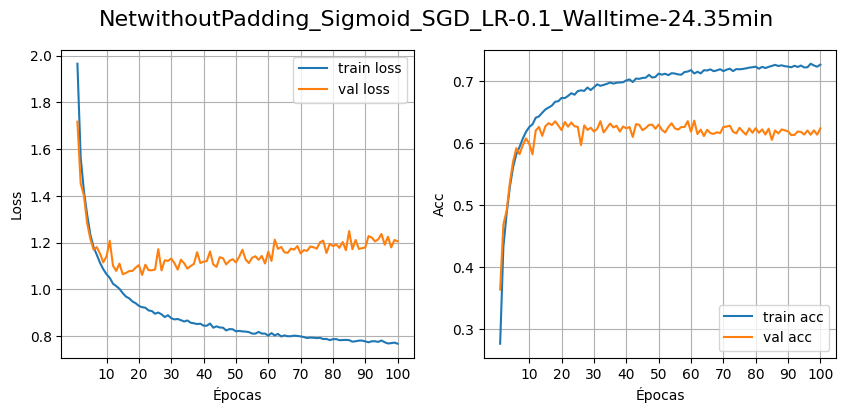

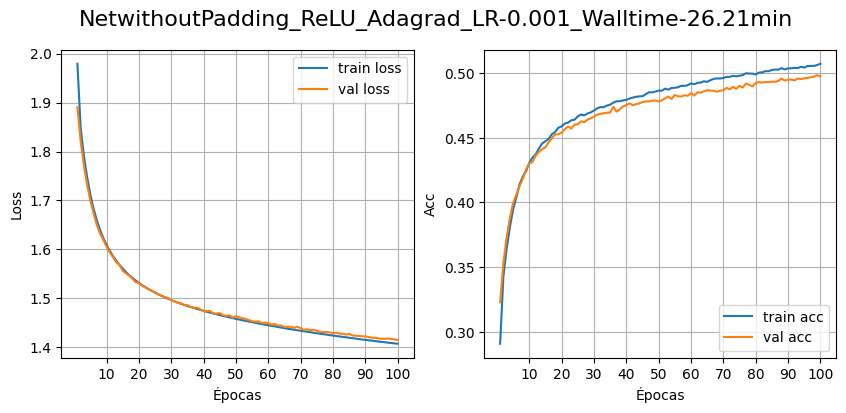

In [ ]:
# Caso default (y baseline)
path = 'https://raw.githubusercontent.com/Cheva94/Diplo_Opt/cheva_dl_lab2/3_DL/Lab2/Outputs/NetwithoutPadding_Sigmoid_SGD_LR-0.1_Walltime-24.35min_Metricas.csv'
plot_loss_and_accuracy(path)

# Mejor caso encontrado
path = 'https://raw.githubusercontent.com/Cheva94/Diplo_Opt/cheva_dl_lab2/3_DL/Lab2/Outputs/NetwithoutPadding_ReLU_Adagrad_LR-0.001_Walltime-26.21min_Metricas.csv'
plot_loss_and_accuracy(path)

Hemos logrado reducir tanto el ruido como el sobreajuste, prácticamente anulándolo. Sin embargo, al accuracy resultante es pobre (apenas llega al 50%).

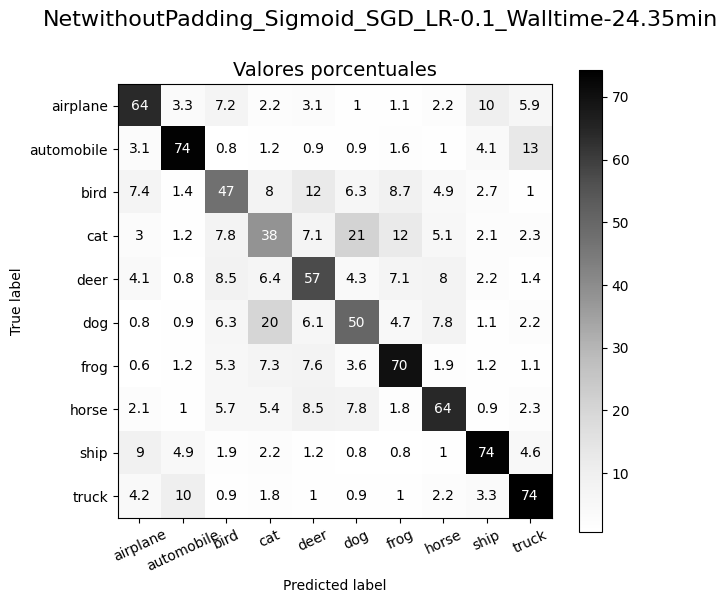

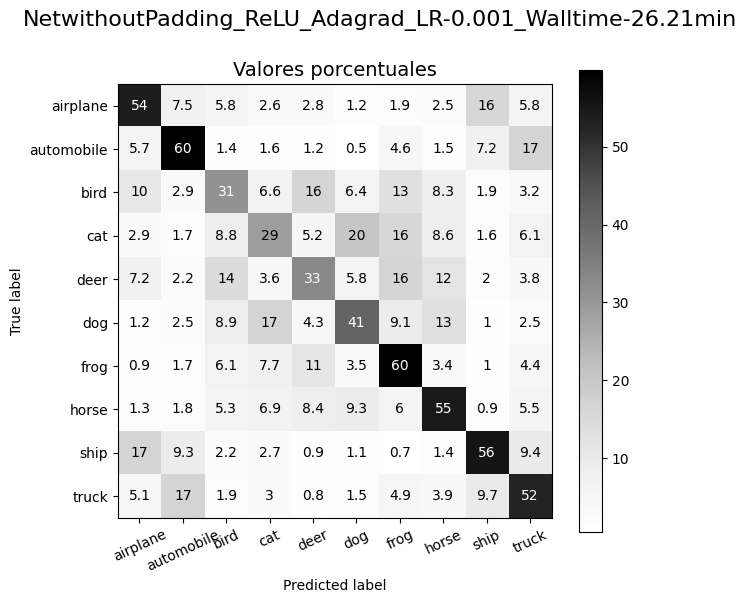

In [ ]:
# Caso default (y baseline)
path = 'https://raw.githubusercontent.com/Cheva94/Diplo_Opt/cheva_dl_lab2/3_DL/Lab2/Outputs/NetwithoutPadding_Sigmoid_SGD_LR-0.1_Walltime-24.35min_Etiquetas.csv'
plotting_confusion_matrix(path, CIFAR_CLASSES)

# Mejor caso encontrado
path = 'https://raw.githubusercontent.com/Cheva94/Diplo_Opt/cheva_dl_lab2/3_DL/Lab2/Outputs/NetwithoutPadding_ReLU_Adagrad_LR-0.001_Walltime-26.21min_Etiquetas.csv'
plotting_confusion_matrix(path, CIFAR_CLASSES)

Vemos que, a pesar del sobreajuste, la red con parámetros por defecto presenta 8/10 clases con más del 50% de aciertos (4 de esas 8 por encima del 70%), mientras que la red refinada presenta 6/10 con valores mayores al 50%, llegando al 60% como máximo.

En ambos casos se aprecian las mismas confusiones:
- Aviones con barcos y viceversa.
- Autos con camiones y viceversa.
- Pájaros con ciervos.
- Gatos con perros y viceversa.
- Ciervos con ranas y viceversa.
- Caballos con perros.

---
# Experimento 2 - Modelo más complejo: afinando el filtro y profundizando la red

## Definición del modelo

En un primer intento de mejora, generamos la siguiente red, la cual consta de 3 capas convolucionales:
- La primera con 3 canales de entrada (RGB de las imágenes) y 10 canales de salida.
- La segunda toma estos 10 canales de salida como canales de entrada y devuelve 20 canales de saldia.
- La tercera toma estos 20 canales de salida como canales de entrada y devuelve 30 canales de saldia.

En ambos casos los filtros son 3x3, el paso es de 1 y el relleno es de 1 (modo 'reflect'), manteniendo el tamaño de entrada en cada capa convolucional. Esto hace que la primera capa convolucional tome las imágenes 32x32x3 y devuelva un mapa de características de 32x32x10. Luego, el max pooling nos deja un mapa de características de 16x16x10. La segunda capa convolucional toma este mapa de 16x16x10, y devuelve otro mapa de 16x16x20, quedando en 8x8x20 luego del max pooling. Finalmente, la tercera capa convolucional toma este mapa de 8x8x20, devolviendo otro de 8x8x30, reduciéndose a 4x4x30 luego del max pooling.

Al aplanar esta salida, la flatten layer es un vector de 480 (=4x4x30) entradas. La capa fully-connected toma estos 480 valores y devuelve 10, uno por cada clase posible.

La función de activación por defecto de esta red es la sigmoide.

Resumiendo, las principales diferencias con la red base son:
- Cantidad de capas convolucionales: tiene una más.
- El tamaño de los filtros: son más pequeños.
- Tiene padding, reflejando los valores de los bordes.

In [ ]:
class CNN3K3P1(nn.Module):
    def __init__(self):
        super(CNN3K3P1, self).__init__()
        # Inicializar 2 capas convolucionales
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=1, padding_mode='reflect')
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding=1, padding_mode='reflect')
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=30, kernel_size=3, padding=1, padding_mode='reflect')

        # Inicializar función de activación. Default: Sigmoide
        self.actfunc = nn.Sigmoid()

        # Inicializar una capa de agrupamiento por máximo
        self.pool = nn.MaxPool2d(2, 2)

        # Inicializar la capa totalmente conectada
        self.fc = nn.Linear(4 * 4 * 30, 10)

    def forward(self, x):
        # Convolución + Activación + Agrupamiento sobre capa 1
        x = self.actfunc(self.conv1(x))
        x = self.pool(x)

        # Convolución + Activación + Agrupamiento sobre capa 2
        x = self.actfunc(self.conv2(x))
        x = self.pool(x)

        # Convolución + Activación + Agrupamiento sobre capa 3
        x = self.actfunc(self.conv3(x))
        x = self.pool(x)

        # Preparar la imagen para la capa totalmente conectada (flatten layer)
        x = x.view(-1, self.fc.in_features)

        # Aplicar la capa totalmente conectada y obtener resultado
        return self.fc(x)

## Corrida default

In [ ]:
# # Instanciamos el modelo
# model = CNN3K3P1()
# # Definimos el optimizador
# optimizer = optim.SGD(model.parameters(), lr=1e-1, momentum=0.9)
# # Corremos el experimento
# train_val(model, criterion, optimizer, train_loader, val_loader, EPOCHS)

## Estudio de la función de activación

In [ ]:
# # La sigmoide es el default
# activation_functions = [nn.LeakyReLU()] # [nn.Tanh(), nn.ReLU(), nn.LeakyReLU()]

# for af in activation_functions:
#     model = CNN3K3P1()
#     model.actfunc = af
#     print(model.actfunc)
#     optimizer = optim.SGD(model.parameters(), lr=1e-1, momentum=0.9)
#     train_val(model, criterion, optimizer, train_loader, val_loader, EPOCHS)

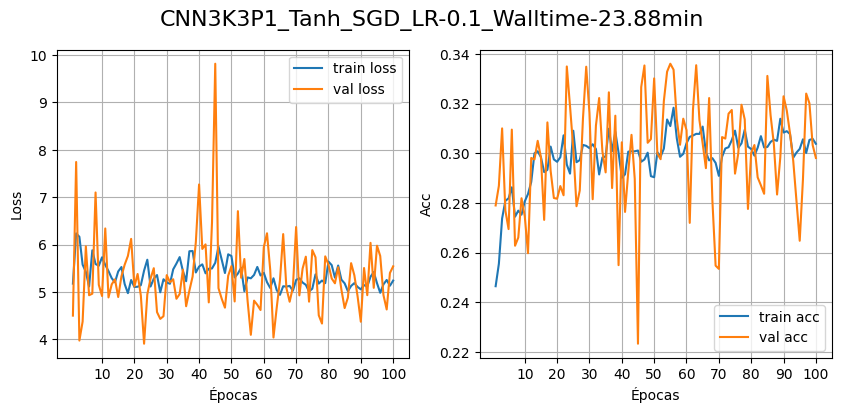

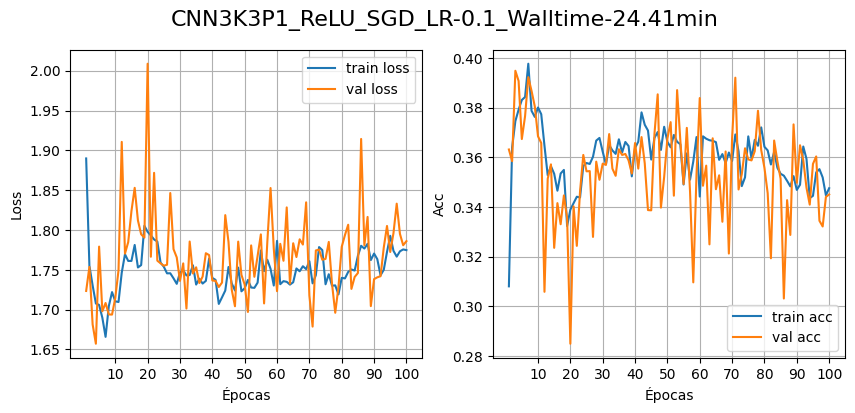

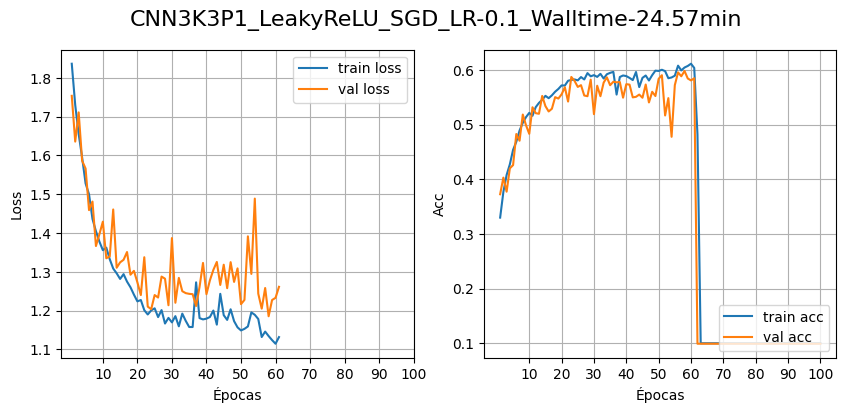

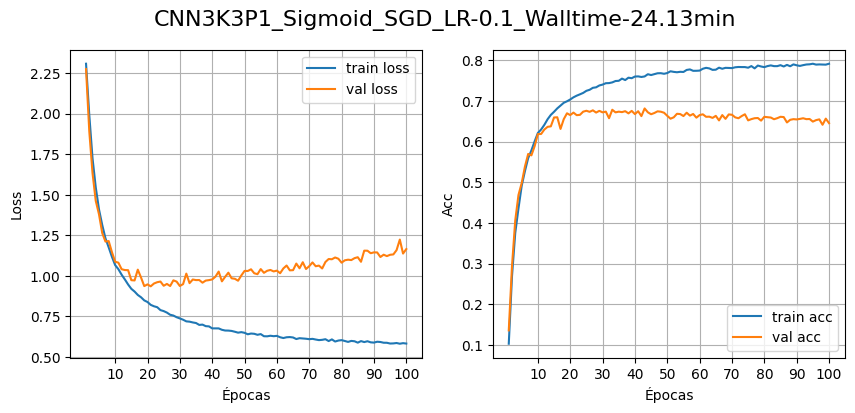

In [ ]:
prefix = 'https://raw.githubusercontent.com/Cheva94/Diplo_Opt/cheva_dl_lab2/3_DL/Lab2/Outputs/CNN3K3P1_'
for path in ['Tanh_SGD_LR-0.1_Walltime-23.88min_Metricas.csv',
             'ReLU_SGD_LR-0.1_Walltime-24.41min_Metricas.csv',
             'LeakyReLU_SGD_LR-0.1_Walltime-24.57min_Metricas.csv',
             'Sigmoid_SGD_LR-0.1_Walltime-24.13min_Metricas.csv']:
    plot_loss_and_accuracy(prefix+path)

Tanto Tanh como ReLU son extremadamente ruidosas. En la LeakyReLU no sabemos qué ocurrió, pero los valores de loss que faltan es porque arrojaban NaN. Nos quedamos con la sigmoide (default), a pesar del sobreajuste.

## Estudio del optimizador

In [ ]:
# # SGD es el default
# optimizadores = [optim.Adam, optim.Adagrad, optim.RMSprop]

# for gd in optimizadores:
#     print(gd)
#     model = CNN3K3P1()
#     # Adagrad no funciona sin esta línea (es un issue ya reportado)
#     model = model.to(device=device)
#     optimizer = gd(model.parameters(), lr=1e-1)
#     train_val(model, criterion, optimizer, train_loader, val_loader, EPOCHS)

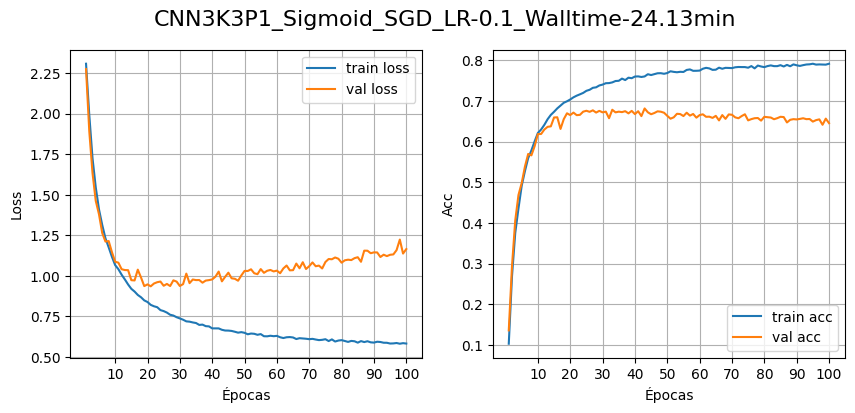

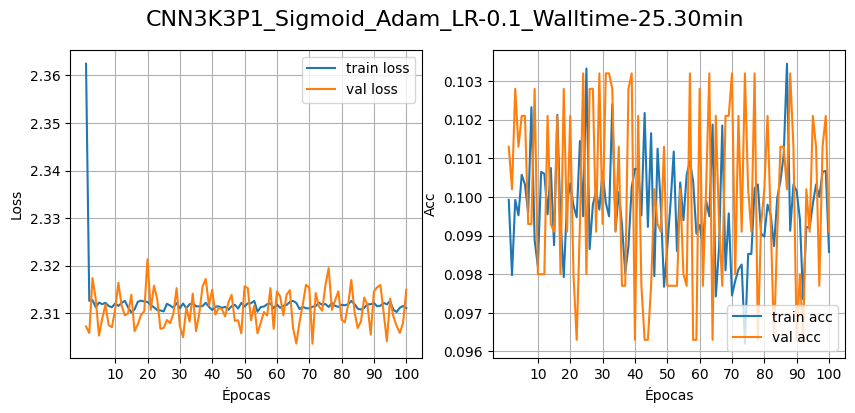

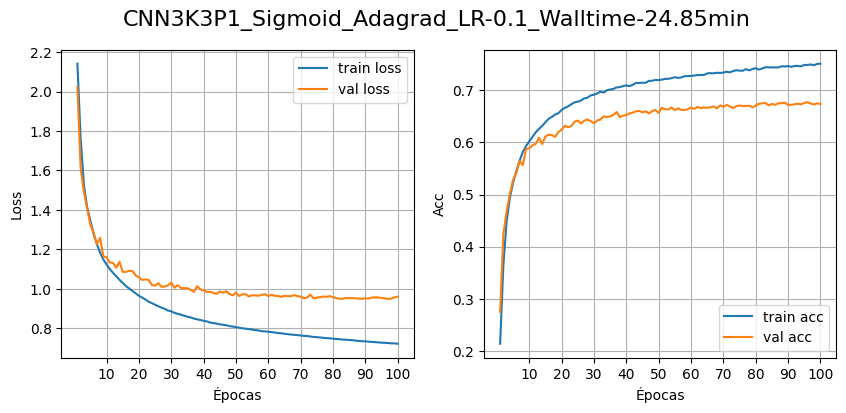

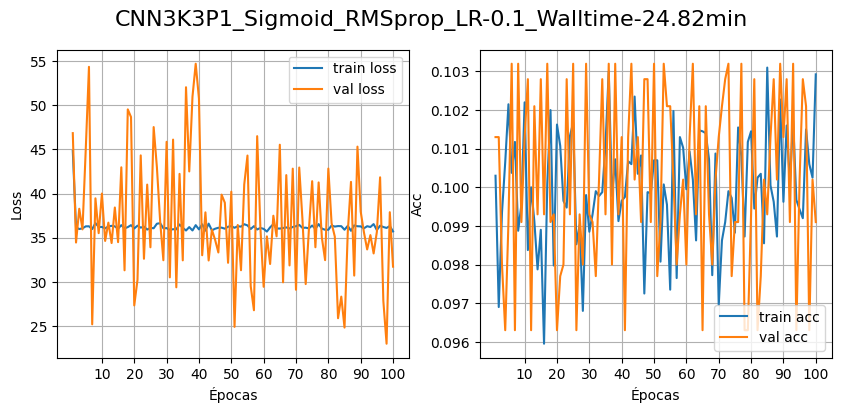

In [ ]:
prefix = 'https://raw.githubusercontent.com/Cheva94/Diplo_Opt/cheva_dl_lab2/3_DL/Lab2/Outputs/CNN3K3P1_'
for path in ['Sigmoid_SGD_LR-0.1_Walltime-24.13min_Metricas.csv',
             'Sigmoid_Adam_LR-0.1_Walltime-25.30min_Metricas.csv',
             'Sigmoid_Adagrad_LR-0.1_Walltime-24.85min_Metricas.csv',
             'Sigmoid_RMSprop_LR-0.1_Walltime-24.82min_Metricas.csv']:
    plot_loss_and_accuracy(prefix+path)

Tanto RMSprop como Adam vuelven a presentar evoluciones ruidosas. Entre SGD (default) y Adagrad, elegimos la segunda ya que presenta un menor sobreajuste, manteniendo un nivel similar de accuracy.

## Estudio de la tasa de aprendizaje

In [ ]:
# # 0.1 es el default
# alphas = [1e-2, 1e-3, 1e-4]

# for lr in alphas:
#     print(lr)
#     model = CNN3K3P1()
#     # Adagrad no funciona sin esta línea (es un issue ya reportado)
#     model = model.to(device=device)
#     # Usamos el optimizador elegido
#     optimizer = optim.Adagrad(model.parameters(), lr=lr)
#     train_val(model, criterion, optimizer, train_loader, val_loader, EPOCHS)

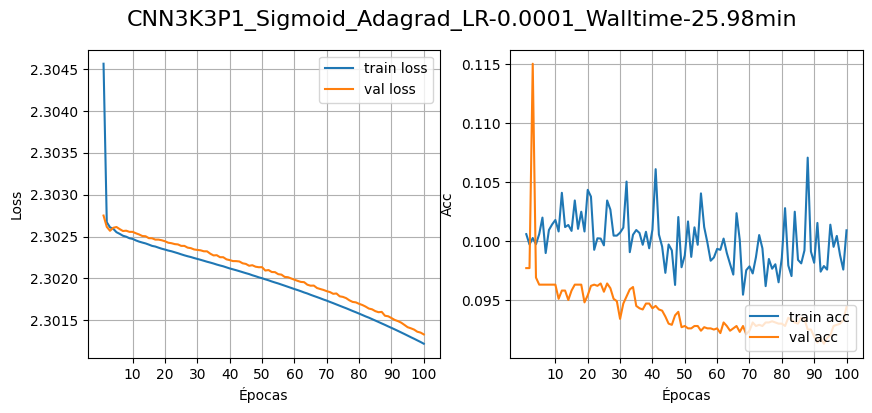

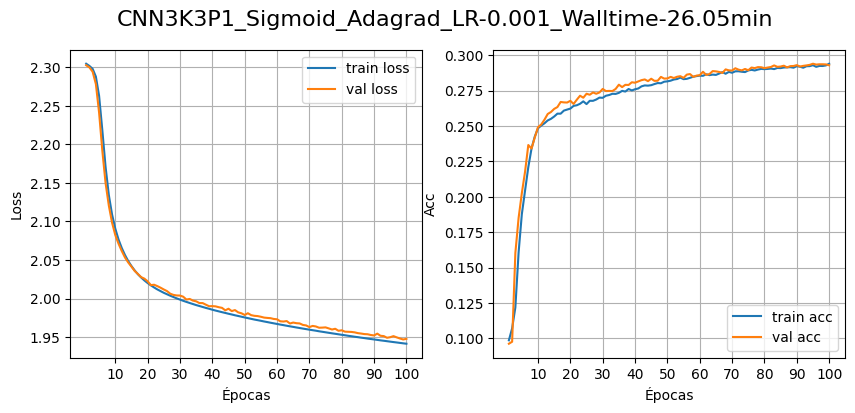

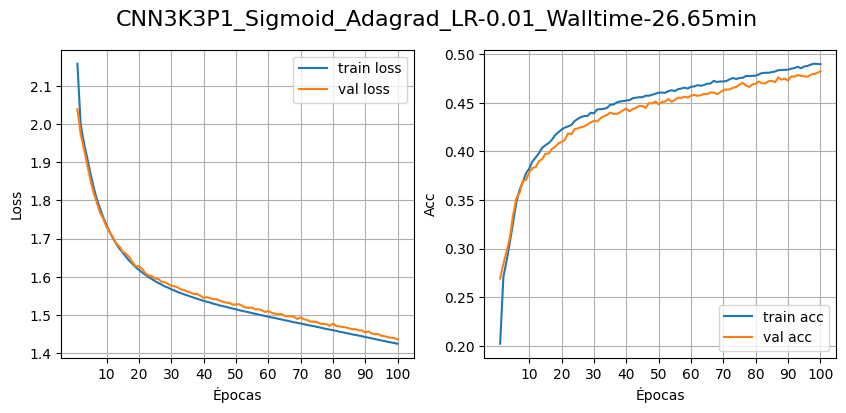

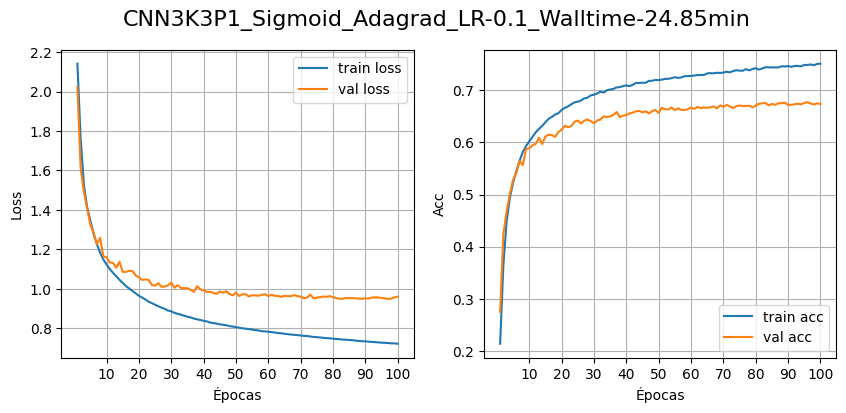

In [ ]:
prefix = 'https://raw.githubusercontent.com/Cheva94/Diplo_Opt/cheva_dl_lab2/3_DL/Lab2/Outputs/CNN3K3P1_'
for path in ['Sigmoid_Adagrad_LR-0.0001_Walltime-25.98min_Metricas.csv',
             'Sigmoid_Adagrad_LR-0.001_Walltime-26.05min_Metricas.csv',
             'Sigmoid_Adagrad_LR-0.01_Walltime-26.65min_Metricas.csv',
             'Sigmoid_Adagrad_LR-0.1_Walltime-24.85min_Metricas.csv']:
    plot_loss_and_accuracy(prefix+path)

Con 0.0001 se obtiene una evolución muy ruidosa del accuracy, a pesar de tener un bajo sobreajuste. Si bien con 0.1 se llega a los mayores valores de accuracy, al pasar a 0.01 y 0.001 el sobreajuste se reduce prácticamente a cero. Nos quedamos con 0.01 ya que alcanza mayor accuracy para igual cantidad de épocas.

## Comparación intrared: default vs mejor

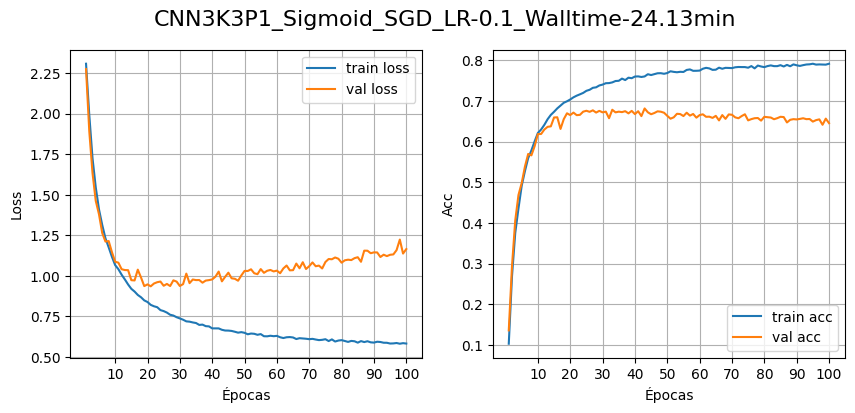

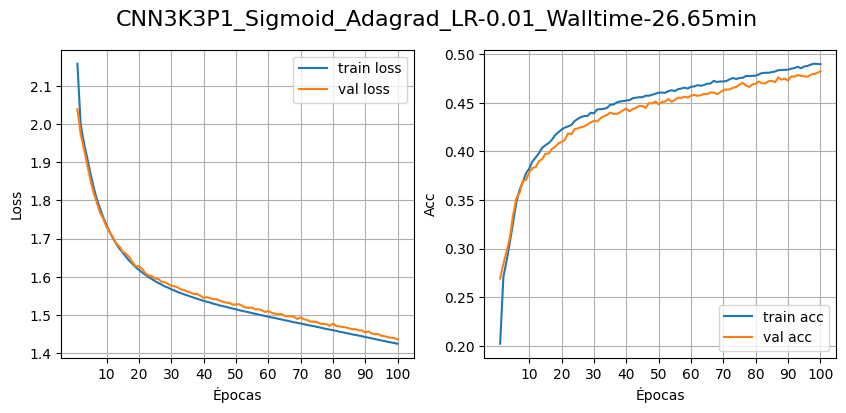

In [ ]:
# Caso default
path = 'https://raw.githubusercontent.com/Cheva94/Diplo_Opt/cheva_dl_lab2/3_DL/Lab2/Outputs/CNN3K3P1_Sigmoid_SGD_LR-0.1_Walltime-24.13min_Metricas.csv'
plot_loss_and_accuracy(path)

# Mejor caso encontrado
path = 'https://raw.githubusercontent.com/Cheva94/Diplo_Opt/cheva_dl_lab2/3_DL/Lab2/Outputs/CNN3K3P1_Sigmoid_Adagrad_LR-0.01_Walltime-26.65min_Metricas.csv'
plot_loss_and_accuracy(path)


Nuevamente, logramos reducir tanto el ruido como el sobreajuste, prácticamente anulándolo, pero seguimos obteniendo una muy baja accuracy, llegando esta vez por debajo del 50%.

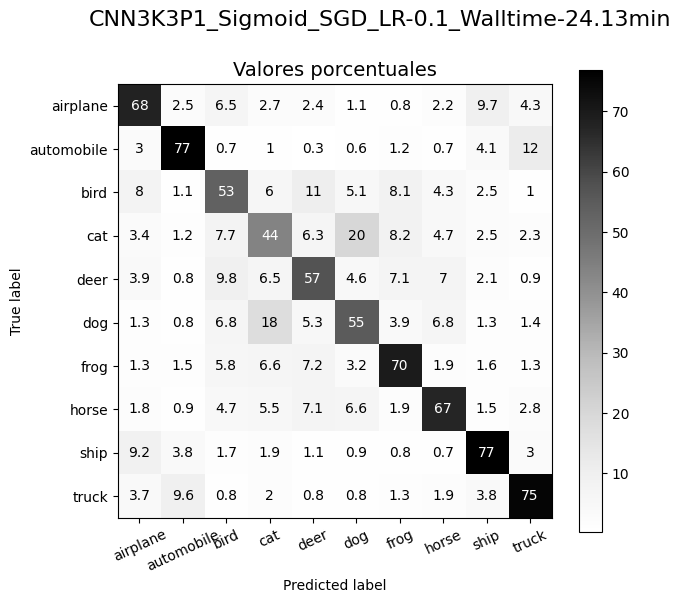

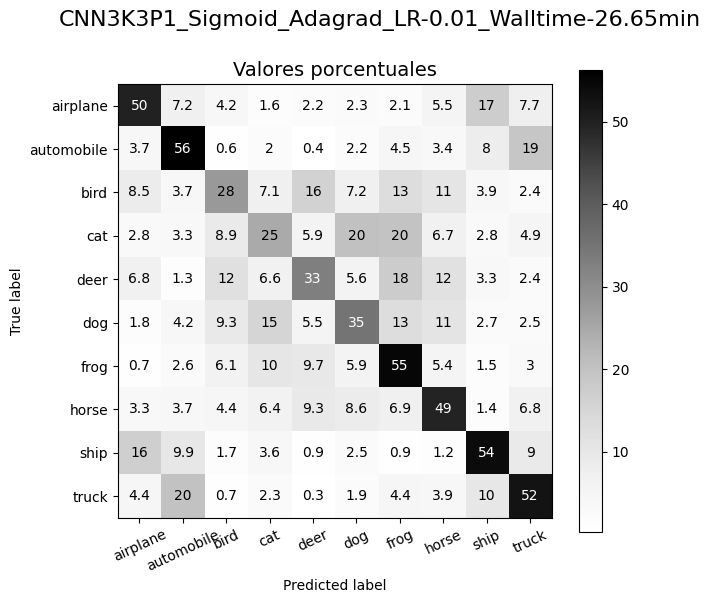

In [ ]:
# Caso default
path = 'https://raw.githubusercontent.com/Cheva94/Diplo_Opt/cheva_dl_lab2/3_DL/Lab2/Outputs/CNN3K3P1_Sigmoid_SGD_LR-0.1_Walltime-24.13min_Etiquetas.csv'
plotting_confusion_matrix(path, CIFAR_CLASSES)

# Mejor caso encontrado
path = 'https://raw.githubusercontent.com/Cheva94/Diplo_Opt/cheva_dl_lab2/3_DL/Lab2/Outputs/CNN3K3P1_Sigmoid_Adagrad_LR-0.01_Walltime-26.65min_Etiquetas.csv'
plotting_confusion_matrix(path, CIFAR_CLASSES)

Nuevamente, a pesar del sobreajuste, la red por defecto presenta 9/10 clases con más del 50% de aciertos (4 de esas 9 con más del 70%), mientras que la red refinada presenta 6/10 con valores mayores al 50%, llegando a 56% como máximo. Las confusiones que se presentan son las mismas que antes.

---
# Experimento 3 - Modelo final: Se profundiza aún más la red y se agrega dropout

## Definición del modelo

En un segundo intento de mejora, generamos la siguiente red, la cual consta de 4 capas convolucionales:
- La primera con 3 canales de entrada (RGB de las imágenes) y 10 canales de salida.
- La segunda toma estos 10 canales de salida como canales de entrada y devuelve 20 canales de saldia.
- La tercera toma estos 20 canales de salida como canales de entrada y devuelve 30 canales de saldia.

En ambos casos los filtros son 3x3, el paso es de 1 y el relleno es de 1 (modo 'reflect'), manteniendo el tamaño de entrada en cada capa convolucional. Esto hace que la primera capa convolucional tome las imágenes 32x32x3 y devuelva un mapa de características de 32x32x10. Luego, el max pooling nos deja un mapa de características de 16x16x10. La segunda capa convolucional toma este mapa de 16x16x10, y devuelve otro mapa de 16x16x20, quedando en 8x8x20 luego del max pooling. Finalmente, la tercera capa convolucional toma este mapa de 8x8x20, devolviendo otro de 8x8x30, reduciéndose a 4x4x30 luego del max pooling.

Al aplanar esta salida, la flatten layer es un vector de 480 (=4x4x30) entradas. La capa fully-connected toma estos 480 valores y devuelve 10, uno por cada clase posible.

La función de activación por defecto de esta red es la sigmoide.

Resumiendo, las principales diferencias con la red base son:
- Cantidad de capas convolucionales: tiene una más.
- El tamaño de los filtros: son más pequeños.
- Tiene padding, reflejando los valores de los bordes.

In [ ]:
class CNN3K4P1_2(nn.Module):
    def __init__(self, dropout=0.0):
        super(CNN3K4P1_2, self).__init__()
        # Inicializar 4 capas convolucionales
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=20, kernel_size=3, padding=1, padding_mode='reflect')
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=20, kernel_size=3, padding=1, padding_mode='reflect')
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=40, kernel_size=3, padding=1, padding_mode='reflect')
        self.conv4 = nn.Conv2d(in_channels=40, out_channels=40, kernel_size=3, padding=1, padding_mode='reflect')

        # Inicializar Dropout
        self.drop1 = nn.Dropout(dropout)
        self.drop2 = nn.Dropout(dropout)

        # Inicializar función de activación. Default: ReLU
        self.actfunc = nn.ReLU()

        # Inicializar una capa de agrupamiento por máximo
        self.pool = nn.MaxPool2d(2, 2)

        # Inicializar capas totalmente conectadas
        self.fc1 = nn.Linear(2560, 10)

    def forward(self, x):
        # Convolución + Activación + Agrupamiento + sobre capa 1
        x = self.actfunc(self.conv1(x))
        x = self.actfunc(self.conv2(x))
        x = self.pool(x)
        x = self.drop1(x)

        # Convolución + Activación + Agrupamiento sobre capa 2
        x = self.actfunc(self.conv3(x))
        x = self.actfunc(self.conv4(x))
        x = self.pool(x)
        x = self.drop2(x)

        # Preparar la imagen para la capa totalmente conectada (flatten layer)
        x = x.view(-1, self.fc1.in_features)

        x = self.actfunc(self.fc1(x))

        # Aplicar la capa totalmente conectada y obtener resultado
        return x

## Corrida default

In [ ]:
# Instanciamos el modelo
drop = 0
model = CNN3K4P1_2(dropout=drop)
# Definimos el optimizador
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
# Corremos el experimento
train_val(model, criterion, optimizer, train_loader, val_loader, EPOCHS, dropout=True)

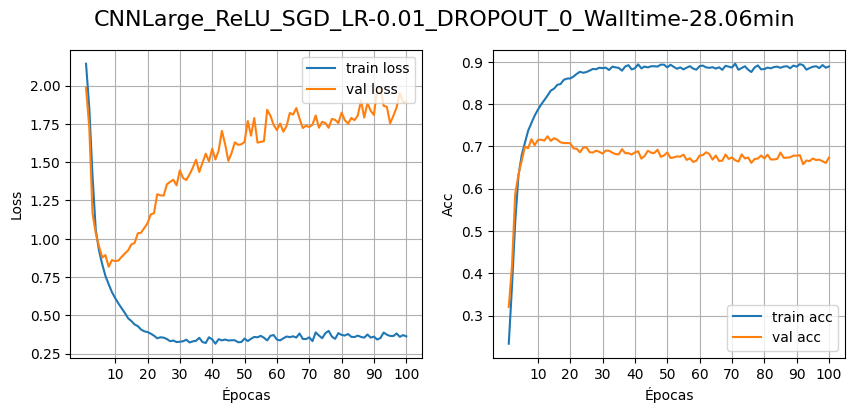

In [10]:
prefix = 'https://raw.githubusercontent.com/Cheva94/Diplo_Opt/ms_dl_lab2/3_DL/Lab2/Outputs/'
path = 'CNNLarge_ReLU_SGD_LR-0.01_DROPOUT_0_Walltime-28.06min_Metricas.csv'
plot_loss_and_accuracy(prefix+path)

## Estudio del dropout

In [ ]:
dropOuts = [0.1, 0.25, 0.5, 0.6]

for drop in dropOuts:
  # Instanciamos el modelo
  model = CNN3K4P1_2(dropout=drop)
  # Definimos el optimizador
  optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
  # Corremos el experimento
  train_val(model, criterion, optimizer, train_loader, val_loader, EPOCHS, dropout=True)

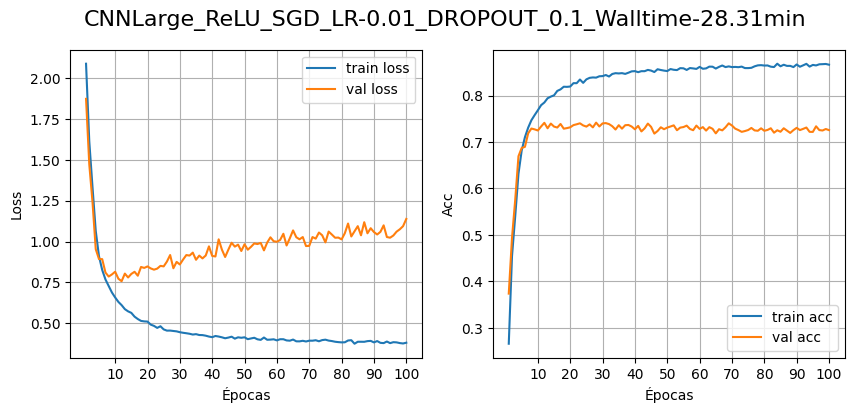

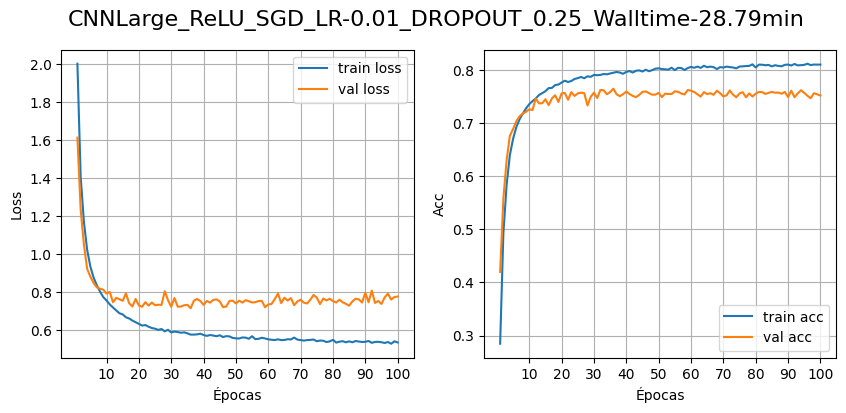

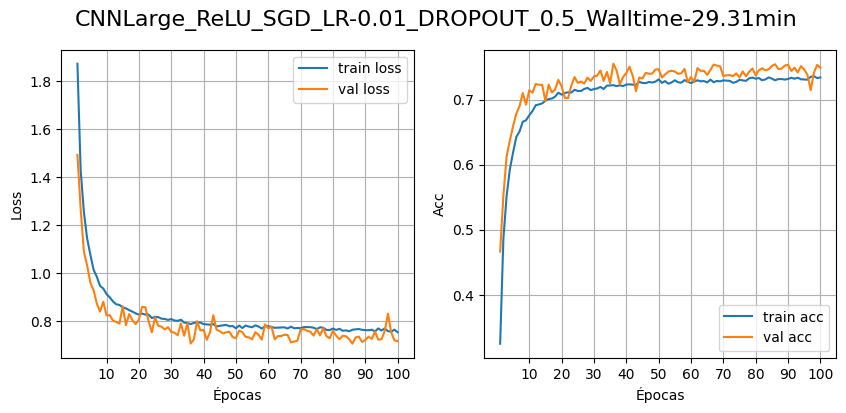

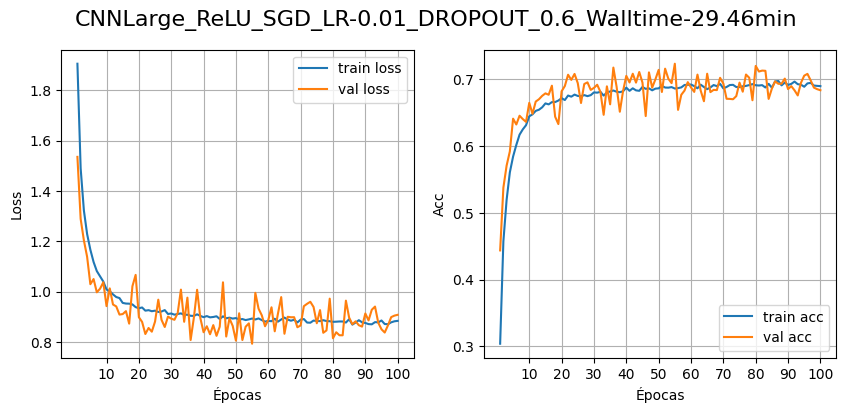

In [15]:
prefix = 'https://raw.githubusercontent.com/Cheva94/Diplo_Opt/ms_dl_lab2/3_DL/Lab2/Outputs/'
paths = ['CNNLarge_ReLU_SGD_LR-0.01_DROPOUT_0.1_Walltime-28.31min_Metricas.csv',
            'CNNLarge_ReLU_SGD_LR-0.01_DROPOUT_0.25_Walltime-28.79min_Metricas.csv',
            'CNNLarge_ReLU_SGD_LR-0.01_DROPOUT_0.5_Walltime-29.31min_Metricas.csv',
            'CNNLarge_ReLU_SGD_LR-0.01_DROPOUT_0.6_Walltime-29.46min_Metricas.csv']
for path in paths:
  plot_loss_and_accuracy(prefix+path)

## Estudio de la tasa de aprendizaje

In [ ]:
lrs = [1e-1, 1e-3, 1e-4]

for lr in lrs:
  # Instanciamos el modelo
  model = CNN3K4P1_2(dropout=0.25)
  # Definimos el optimizador
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
  # Corremos el experimento
  train_val(model, criterion, optimizer, train_loader, val_loader, EPOCHS, dropout=True)

---
# Comparación entre redes y conclusiones

In [ ]:
# Baseline
path = 'https://raw.githubusercontent.com/Cheva94/Diplo_Opt/cheva_dl_lab2/3_DL/Lab2/Outputs/NetwithoutPadding_Sigmoid_SGD_LR-0.1_Walltime-24.35min_Metricas.csv'
plot_loss_and_accuracy(path)

# Mejor caso de NetwithoutPadding
path = 'https://raw.githubusercontent.com/Cheva94/Diplo_Opt/cheva_dl_lab2/3_DL/Lab2/Outputs/NetwithoutPadding_ReLU_Adagrad_LR-0.001_Walltime-26.21min_Metricas.csv'
plot_loss_and_accuracy(path)

# Mejor caso de CNN3K3P1
path = 'https://raw.githubusercontent.com/Cheva94/Diplo_Opt/cheva_dl_lab2/3_DL/Lab2/Outputs/CNN3K3P1_Sigmoid_Adagrad_LR-0.01_Walltime-26.65min_Metricas.csv'
plot_loss_and_accuracy(path)

In [ ]:
# Baseline
path = 'https://raw.githubusercontent.com/Cheva94/Diplo_Opt/cheva_dl_lab2/3_DL/Lab2/Outputs/NetwithoutPadding_Sigmoid_SGD_LR-0.1_Walltime-24.35min_Etiquetas.csv'
plotting_confusion_matrix(path, CIFAR_CLASSES)

# Mejor caso de NetwithoutPadding
path = 'https://raw.githubusercontent.com/Cheva94/Diplo_Opt/cheva_dl_lab2/3_DL/Lab2/Outputs/NetwithoutPadding_ReLU_Adagrad_LR-0.001_Walltime-26.21min_Etiquetas.csv'
plotting_confusion_matrix(path, CIFAR_CLASSES)

# Mejor caso de CNN3K3P1
path = 'https://raw.githubusercontent.com/Cheva94/Diplo_Opt/cheva_dl_lab2/3_DL/Lab2/Outputs/CNN3K3P1_Sigmoid_Adagrad_LR-0.01_Walltime-26.65min_Etiquetas.csv'
plotting_confusion_matrix(path, CIFAR_CLASSES)